# ChannelAI 마케팅 AI 모델 설계 (더미 데이터 기반)

이 노트북은 백엔드/플라스크(Flask)에 AI 기능(선형회귀, 이상탐지 등)을 붙이기 전에, **파이썬 환경에서 알고리즘을 먼저 테스트하고 눈으로 확인해보기 위한 실험 공간**입니다.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 한글 폰트 설정 (윈도우 환경: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료! (scikit-learn 이 없다면 '!pip install scikit-learn'을 실행하세요)")

라이브러리 로드 완료! (scikit-learn 이 없다면 '!pip install scikit-learn'을 실행하세요)


## 1. 다운로드 받은 CSV 실제 데이터 로드 및 전처리
제공해주신 CSV 파일을 분석하여 일일 지출 및 클릭 합계를 추출합니다.

In [3]:
# 다운로드 받은 실제 CSV 데이터 로드
csv_path = "channel_ai_db_export_1771812133027.csv"
raw_df = pd.read_csv(csv_path)

# 날짜별 총 비용, 클릭수 계산 (일별 통합)
df = raw_df.groupby('날짜').agg({
    '비용': 'sum',
    '클릭': 'sum'
}).reset_index()

# 컬럼명 변경 (기존 머신러닝 코드와 호환을 위해)
df = df.rename(columns={'날짜': 'date', '비용': 'cost', '클릭': 'clicks'})

# 날짜 오름차순 정렬
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print("✅ 실제 CSV 데이터 로드 완료!\n")
display(df.tail(10)) # 생성된 데이터 끝부분 확인

,date,cost,clicks
20,2026-01-21,350000,5000
21,2026-01-22,162151,8266
22,2026-01-23,174571,8950
23,2026-01-24,160522,7263
24,2026-01-25,196355,9808
25,2026-01-26,182121,8745
26,2026-01-27,180414,9263
27,2026-01-28,192164,9378
28,2026-01-29,198216,9931
29,2026-01-30,188080,9258


## 2. 선형 회귀 (Linear Regression) 미래 예측
과거 비용(Cost) 추이로 내일(31일차), 모레(32일차) 비용을 예측합니다.

In [12]:
# 머신러닝을 위해 날짜를 단순 숫자로 차원 변환 (0, 1, 2 ...)
X = np.arange(len(df)).reshape(-1, 1)
y = df['cost'].values

# 선형회귀 모델 학습
model = LinearRegression()
model.fit(X, y)

# 향후 3일 예측 (마지막 인덱스 + 1, + 2, + 3)
last_idx = len(df)
future_X = np.array([[last_idx], [last_idx+1], [last_idx+2]])
future_pred = model.predict(future_X)

print(f"오늘까지의 마지막 비용: {df['cost'].iloc[-1]:,.0f} 원")
print(f"내일 예상 비용: {int(future_pred[0]):,.0f} 원")

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['cost'], label='실제 광고비', marker='o')
plt.plot(pd.date_range(start=df['date'].iloc[-1], periods=4)[1:], future_pred, 
         label='향후 예측', linestyle='--', color='red', marker='x')
plt.title("머신러닝(선형회귀) 기반 예산 소진 예측")
plt.legend()
plt.show()

KeyError: 'cost'

## 3. 이상 탐지 (Anomaly Detection) - Z-Score 방식
갑자기 돈이 비정상적으로 많이 나간 날(빨간불)을 찾아냅니다.

🚨 [경고] 비정상적인 데이터가 감지되었습니다:
         date    cost
20 2026-01-21  350000


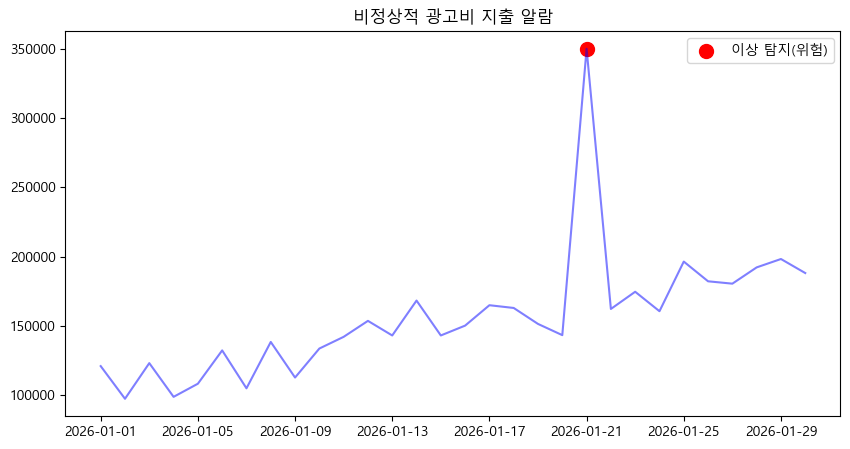

In [5]:
# --- 3. 이상 탐지 (Anomaly Detection) - Z-Score 방식 ---
# 요약: (현재값 - 평균) / 표준편차
# 값이 2 이상이거나 -2 이하면 '매우 비정상적'인 상태로 판단합니다.
mean_cost = df['cost'].mean()
std_cost = df['cost'].std()

df['z_score'] = (df['cost'] - mean_cost) / std_cost
df['anomaly'] = df['z_score'].apply(lambda x: True if abs(x) > 2 else False)

# 이상치 발생한 날만 뽑아보기
anomalies = df[df['anomaly'] == True]
print(f"Z-score 평균: {mean_cost:,.0f}, 표준편차: {std_cost:,.0f}")
print("-" * 50)
if not anomalies.empty:
    print("🚨 [경고] 비정상적인 데이터가 감지되었습니다:")
    display(anomalies[['date', 'cost', 'z_score']])
else:
    print("✅ 비정상적인 데이터가 발견되지 않았습니다.")

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['cost'], color='blue', alpha=0.5)
plt.scatter(anomalies['date'], anomalies['cost'], color='red', s=100, label='이상 탐지(위험)')
plt.title("비정상적 광고비 지출 알람")
plt.legend()
plt.show()